In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import BitsAndBytesConfig
from tqdm.auto import tqdm
from anycache import anycache
from open_pref_eval.plot.radar import radar_plot
from open_pref_eval.helpers.mem import clear_mem


quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [3]:
datasets = get_default_datasets(450)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 378
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 450
 })]

In [ ]:
models = [
    'snake7gun/tiny-random-qwen3',

    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B",
    "Qwen/Qwen3-8B",
    "unsloth/Qwen3-14B",

    "microsoft/Phi-4-mini-instruct", # 4b
    
    "soob3123/amoral-gemma3-4B-v2",
    "unsloth/gemma-3-4b-it",
    
    # "mlabonne/Qwen3-4B-abliterated",
    # "unsloth/Qwen3-4B",
    "wassname/qwen-7B-codefourchan",
    "opencompass/CompassJudger-1-7B-Instruct",




    # "unsloth/gemma-2-9b-it",
    # 'google/gemma-2-2b',
    # "CohereLabs/c4ai-command-r7b-12-2024",
    # 'emergent-misalignment/Qwen-Coder-Insecure',
    # "drfellx/emergent_misalignment_test_qwen2.5-7B-Instruct",
    # "dpasch01/pp-llama3-8b-right-wing",
    # "dpasch01/pp-llama3-8b-left-wing",
    # "unsloth/DeepSeek-R1-Distill-Qwen-7B"
]

In [5]:
from open_pref_eval.scoring import first_nonzero, score_1st_diverg, score_preferences, score_ipo, score_cumsum, score_weighted, score_weighted_prob, score_with_entropy_weight, score_f_alpha_divergance, score_f_divergance, score_agg, score_certainty_weighted, score_seq_entropy_weighted, score_power_mean, score_with_decay, score_percentile, score_1st_diverg, score_perplexity_ratio, score_information_weighted, score_uncertainty_aware, score_confidence_weighted
score_fns = {
    "preferences": score_preferences,
    # "cumsum": score_cumsum,
    # "weighted": score_weighted, # littlediff
    "weighted_prob": score_weighted_prob, # nan
    "entropy_weight": score_with_entropy_weight,
    # "f_alpha_divergance": score_f_alpha_divergance,
    # "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "seq_entropy_weighted": score_seq_entropy_weighted,
    "certainty_weighted": score_certainty_weighted,
    # "power_mean": score_power_mean,
    "with_decay": score_with_decay,
    "percentile": score_percentile,
    # "1st_diverg": score_1st_diverg,
    # "perplexity_ratio": score_perplexity_ratio,
    'information_weighted': score_information_weighted,
    'uncertainty_aware': score_uncertainty_aware,
    'confidence_weighted': score_confidence_weighted,
    "ipo": score_ipo,

}
from functools import partial
from open_pref_eval.scoring import score_ipo, score_preferences, score_confidence_weighted, score_with_entropy_weight, score_seq_entropy_weighted
score_fns = {
    "preferences": score_preferences,
    # "cumsum": score_cumsum,
    # "weighted": score_weighted, # littlediff
    # "weighted_prob": score_weighted_prob, # nan
    # "with_weight": score_with_weight,
    # "f_alpha_divergance": score_f_alpha_divergance,
    # "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "ipo": score_ipo,
    "seq_entropy_weighted": score_seq_entropy_weighted,
    # "certainty_weighted": score_certainty_weighted,
    # "power_mean": score_power_mean,
    # "with_decay": score_with_decay,
    # "percentile": score_percentile,
    # "1st_diverg": score_1st_diverg,
    # "perplexity_ratio": score_perplexity_ratio,
    'confidence_wighted0.5': partial(score_confidence_weighted, T=0.5),
    'confidence_weighted': score_confidence_weighted,
    'confidence_weighted5': partial(score_confidence_weighted, T=5.0),
    'confidence_weighted10': partial(score_confidence_weighted, T=10.0),
    'with_entropy_weight0.5': partial(score_with_entropy_weight, alpha=0.5),
    'with_entropy_weight': score_with_entropy_weight,
    'with_entropy_weight5': partial(score_with_entropy_weight, alpha=5.0),
    'with_entropy_weight10': partial(score_with_entropy_weight, alpha=10.0),

}


In [6]:
@anycache('.anycache2')
def eval_model(model_id):
    print(f"Evaluating {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, ) #trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_id, 
        torch_dtype=torch.bfloat16, 
        quantization_config=quantization_config, device_map="auto", 
    # trust_remote_code=True
    )
    
    # Evaluate the model
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results, df_raw = evaluate_model(
            model=model,
            tokenizer=tokenizer,
            datasets=datasets,
            batch_size=6,
            max_length=1024,
            max_prompt_length=512,
            verbose=1,
            score_fn=score_fns
        ) 
    return results, df_raw

data = []
for model_id in tqdm(models):
    results, df_raw = eval_model(model_id)
    clear_mem()
    data.append(df_raw)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating snake7gun/tiny-random-qwen3


  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:02:26.156 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:02:32.230 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:02:32.313 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-25 06:02:32.496 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:02:32.642 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:450]:   0%|          | 0/63 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating Qwen/Qwen3-1.7B


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:03:08.574 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:03:46.703 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:03:47.732 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-25 06:03:50.424 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:03:52.384 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:450]:   0%|          | 0/63 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating Qwen/Qwen3-4B


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:06:53.266 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 06:08:08.813 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:08:10.389 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-25 06:08:13.673 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 06:08:16.603 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:450]:   0%|          | 0/63 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:450]:   0%|          | 0/75 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating Qwen/Qwen3-8B


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.9k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]


KeyboardInterrupt



In [35]:
import pandas as pd
df = pd.concat(data)
df['correct'] = (df['score_with_entropy_weight__sigmoid'] >= 0.5).astype(int) 
df.groupby(['model', 'dataset'])['correct'].mean().unstack()

dataset,ethics_expression_preferences-commonsense-test[:450],ethics_expression_preferences-deontology-test[:450],ethics_expression_preferences-justice-test[:450],ethics_expression_preferences-utilitarianism-test[:450],imdb_preferences-test[:450],mmlu_preferences-elementary_mathematics-test[:450],toxic-dpo-v0.2-train[:450],truthful_qa_preferences-validation[:450]
model,,,,,,,,
Qwen/Qwen3-1.7B,0.273333,0.646667,0.244444,0.324444,0.184444,0.089947,0.680000,0.317778
Qwen/Qwen3-4B,0.266667,0.622222,0.275556,0.351111,0.175556,0.111111,0.726667,0.331111
snake7gun/tiny-random-qwen3,0.235556,0.464444,0.313333,0.320000,0.111111,0.111111,0.535556,0.282222


In [1]:
df.groupby(['model', 'dataset'])[cols].apply(lambda x: x.isna().mean())

NameError: name 'df' is not defined

In [9]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = s.replace('validation', 'test')
    s = s.replace('train', 'test')
    s = '-'.join(s.split('-test')[:-1])
    return s

df2 = df.copy()
df2['dataset'] = df2['dataset'].apply(rename_ds)
df2['dataset'].unique()

array(['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology'], dtype=object)

In [10]:
import numpy as np


def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # 2. Hard datasets should be low (if you have a hard_math dataset)
    hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    contrasts = [scores[ds].std() / scores[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread +                 # specific contrast we expect
        hard_math_penalty               # weight hard dataset performance
    ) / 10  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,

    }


cols = [c for c in df2.columns if 'score' in c]
res = {}
for c in cols:
    v = evaluate_scoring_method(df2, c)
    res[c] = v

    # df2['correct2'] = df2[c]>0.5
    # v = evaluate_scoring_method(df2, 'correct2')
    # res[f'{c}_bool'] = v


res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
# res

In [11]:
# only show the ones in [0, 1] range
df_metrics = res[(res['min'] >= 0) & (res['max'] <= 1)].sort_values('discrimination', ascending=False)
df_metrics

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,hard_math,min,max
score_preferences__correct,0.341489,0.182222,0.679114,0.181808,0.002222,0.147266,0.000000e+00,1.000000
score_confidence_wighted0.5__correct,0.405975,0.182222,0.771786,0.176393,0.422222,0.104938,0.000000e+00,1.000000
score_confidence_weighted__correct,0.405963,0.182222,0.779008,0.153048,0.448889,0.103175,0.000000e+00,1.000000
score_with_entropy_weight5__correct,0.365815,0.163333,0.783836,0.140129,0.108889,0.090829,0.000000e+00,1.000000
score_with_entropy_weight10__correct,0.354149,0.142222,0.777288,0.125395,0.084444,0.089947,0.000000e+00,1.000000
score_ipo__correct,0.404755,0.182222,0.773836,0.125312,0.482222,0.128748,0.000000e+00,1.000000
score_confidence_weighted5__correct,0.403114,0.181111,0.771839,0.121179,0.491111,0.119929,0.000000e+00,1.000000
score_with_entropy_weight__correct,0.378061,0.180000,0.790278,0.118415,0.208889,0.104056,0.000000e+00,1.000000
score_with_entropy_weight10__sigmoid,0.561414,0.710693,0.997122,0.108750,0.068457,0.415432,3.864588e-21,1.000000
score_confidence_weighted10__correct,0.402329,0.182222,0.773386,0.108304,0.493333,0.128748,0.000000e+00,1.000000


In [12]:

# now only the ones where random calibration is > 0.9
df_metrics = df_metrics[df_metrics['random_calibration'] > 0.8]

# and discrimination is at least 50% as good as ipo
df_metrics = df_metrics[df_metrics['discrimination'] > (0.3 * df_metrics.loc['score_ipo__sigmoid', 'discrimination'])]

# and toxic_spread > 0
df_metrics = df_metrics[df_metrics['toxic_spread'] > 0.01]

# and imdb means is as at least 80% as good as ipo
df_metrics = df_metrics[df_metrics['imdb_mean'] > (0.8 * df_metrics.loc['score_ipo__sigmoid', 'imdb_mean'])]
df_metrics

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,hard_math,min,max
score_with_entropy_weight10__sigmoid,0.561414,0.710693,0.997122,0.108750,0.068457,0.415432,3.864588e-21,1.0
score_with_entropy_weight5__sigmoid,0.574851,0.774481,0.999558,0.104810,0.065041,0.426207,6.230039e-11,1.0
score_confidence_wighted0.5__sigmoid,0.603364,0.854198,0.989023,0.096283,0.193366,0.472245,1.187436e-08,1.0
score_confidence_weighted__sigmoid,0.602244,0.854314,0.992476,0.078586,0.198730,0.480478,3.930181e-07,1.0
score_confidence_weighted5__sigmoid,0.602731,0.853808,0.995858,0.074217,0.207313,0.523626,3.464520e-07,1.0
score_confidence_weighted10__sigmoid,0.601645,0.853915,0.996145,0.070960,0.208336,0.530075,3.054738e-07,1.0
score_ipo__sigmoid,0.600483,0.854241,0.996632,0.066508,0.210124,0.536689,3.054738e-07,1.0
score_with_entropy_weight__sigmoid,0.590737,0.839866,0.997395,0.057927,0.126719,0.492886,2.104789e-07,1.0
score_with_entropy_weight0.5__sigmoid,0.595943,0.847489,0.999563,0.057235,0.166388,0.515096,2.700835e-07,1.0


score_with_entropy_weight10__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.369245,0.606264,0.627511,0.510251,0.522079,0.736450,0.609751,0.588717
Qwen/Qwen3-4B,0.402928,0.599439,0.562913,0.595301,0.551180,0.684936,0.621683,0.592239
snake7gun/tiny-random-qwen3,0.474123,0.476209,0.436185,0.529182,0.456638,0.551331,0.553226,0.500086


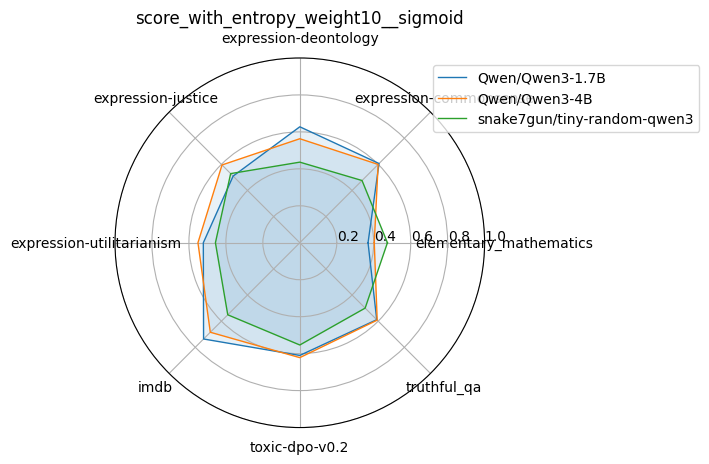

score_with_entropy_weight5__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.376765,0.613425,0.635521,0.484574,0.526830,0.799332,0.593804,0.584912
Qwen/Qwen3-4B,0.422912,0.596350,0.580146,0.561034,0.548800,0.749630,0.610537,0.583552
snake7gun/tiny-random-qwen3,0.478945,0.482781,0.449665,0.524647,0.466861,0.543657,0.545496,0.504413


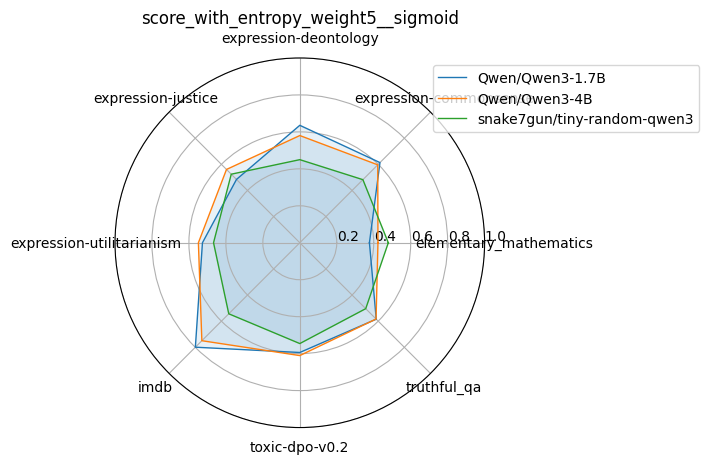

score_confidence_wighted0.5__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.475272,0.616931,0.714175,0.501422,0.594378,0.851450,0.669612,0.540471
Qwen/Qwen3-4B,0.466837,0.611706,0.747959,0.547918,0.584104,0.856947,0.684871,0.562123
snake7gun/tiny-random-qwen3,0.474625,0.479690,0.495434,0.478845,0.489047,0.521995,0.491505,0.481044


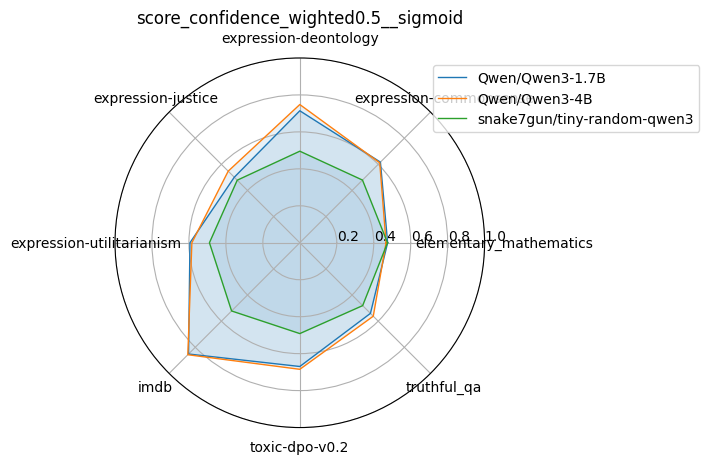

score_confidence_weighted__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.483513,0.592327,0.668350,0.470010,0.560777,0.851356,0.668006,0.523812
Qwen/Qwen3-4B,0.473911,0.590112,0.697901,0.502777,0.556031,0.857272,0.686076,0.547229
snake7gun/tiny-random-qwen3,0.484012,0.481726,0.493155,0.487585,0.499926,0.522115,0.487345,0.483943


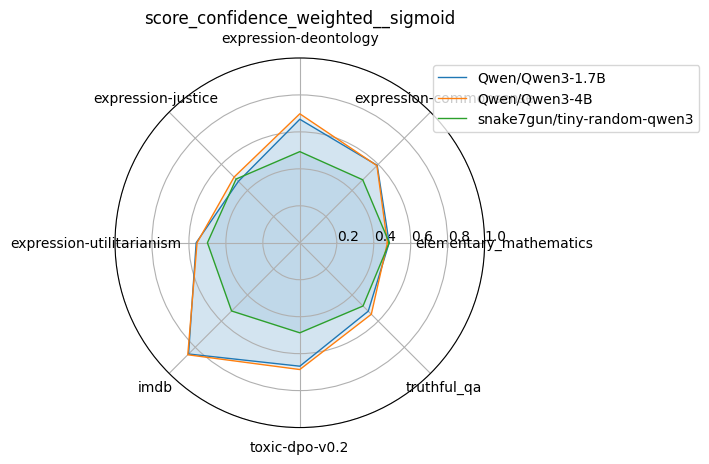

score_confidence_weighted5__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.538171,0.562892,0.584906,0.451453,0.522497,0.851042,0.667727,0.531175
Qwen/Qwen3-4B,0.538545,0.565837,0.608155,0.452594,0.519798,0.856574,0.688744,0.551218
snake7gun/tiny-random-qwen3,0.494163,0.490135,0.489156,0.493719,0.509278,0.522265,0.481431,0.486715


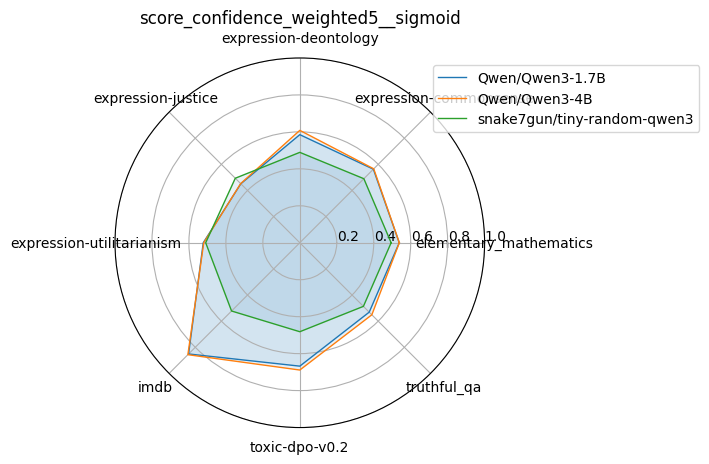

score_confidence_weighted10__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.546653,0.558247,0.572780,0.451075,0.518134,0.851407,0.667920,0.533121
Qwen/Qwen3-4B,0.548178,0.563909,0.595959,0.446989,0.514508,0.856424,0.689166,0.552792
snake7gun/tiny-random-qwen3,0.495394,0.492492,0.488309,0.493397,0.509116,0.521747,0.480830,0.487876


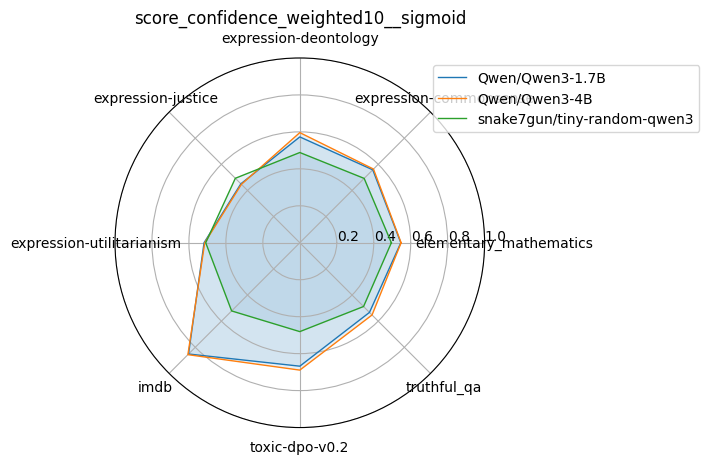

score_ipo__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.555040,0.553602,0.560551,0.451170,0.513918,0.851450,0.668026,0.535180
Qwen/Qwen3-4B,0.557708,0.559925,0.584095,0.441453,0.508847,0.857033,0.689677,0.554342
snake7gun/tiny-random-qwen3,0.497319,0.492619,0.488893,0.493663,0.510488,0.521925,0.479553,0.488598


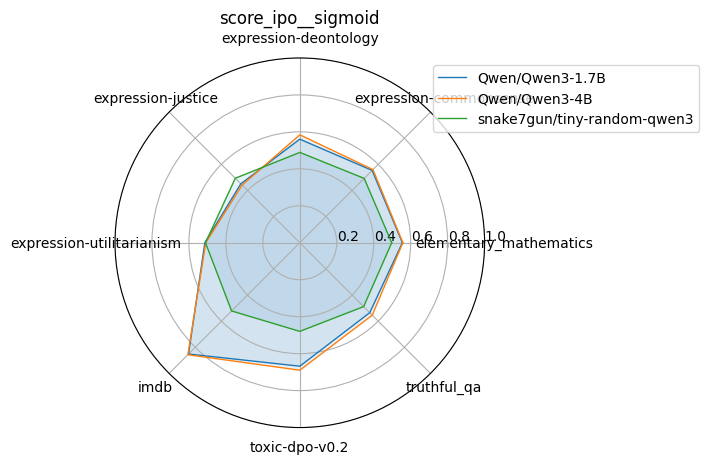

score_with_entropy_weight__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.480305,0.568745,0.597159,0.441364,0.506381,0.843876,0.604412,0.533768
Qwen/Qwen3-4B,0.505840,0.573584,0.587581,0.464550,0.512255,0.835855,0.639599,0.547397
snake7gun/tiny-random-qwen3,0.492512,0.496541,0.478789,0.507236,0.509462,0.523029,0.512880,0.500394


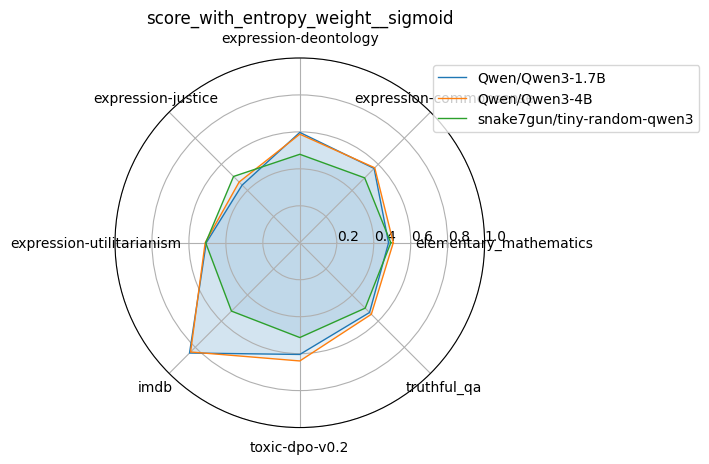

score_with_entropy_weight0.5__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-1.7B,0.517535,0.560180,0.580420,0.443681,0.509324,0.848284,0.635216,0.533043
Qwen/Qwen3-4B,0.531774,0.567768,0.587271,0.451354,0.508951,0.846694,0.665465,0.549775
snake7gun/tiny-random-qwen3,0.495979,0.495054,0.483048,0.501317,0.511911,0.521356,0.499077,0.495755


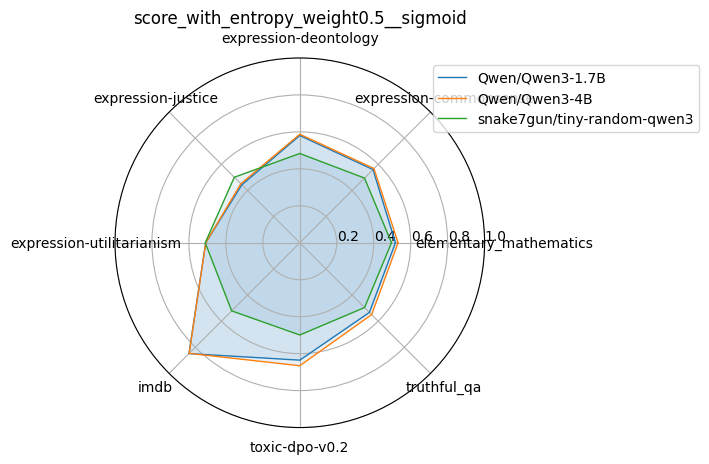

In [13]:

cols = df_metrics.index#.tolist()
for c in cols:
    # df2['correct2'] = df2[c]>0
    df_agg = df2.pivot_table(index='model', columns='dataset', values=c)
    print(c)
    display(df_agg)
    radar_plot(df_agg.T)
    plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
    plt.title(c)
    plt.show()
